In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import turbo_seti.find_event as find
import blimpy as bl
import glob

In [2]:
%matplotlib inline

# Spectral Occupancy

When exploring data from radio observations with the intent of searching for interesting signals, one must be aware of human sourced radio signals (RFI). Below is a typical frequency distribution of L-band data collected at Green Bank Telescope (GBT). There are a large number of hits centered around 1200 MHz and between 1500-1600MHz. These bands are used by the Global Navigation Satellite System and Mobile-satellite service [Price et al 2020](https://arxiv.org/pdf/1906.07750.pdf). 



In [3]:
def calculate_hist(dat_file, bin_width=1): 
    """calculates a histogram of the number of hits for a single .dat file"""
    #read the file into a pandas dataframe
    tbl = find.read_dat(dat_file)

    #make the bins for the histogram
    min_freq = int(min(tbl["Freq"]))
    max_freq = np.round(max(tbl["Freq"]))
    bins = np.linspace(min_freq, max_freq, int((max_freq-min_freq)/bin_width) , endpoint=True)
    hist, bin_edges = np.histogram(tbl["Freq"], bins=bins)
    return hist, bin_edges

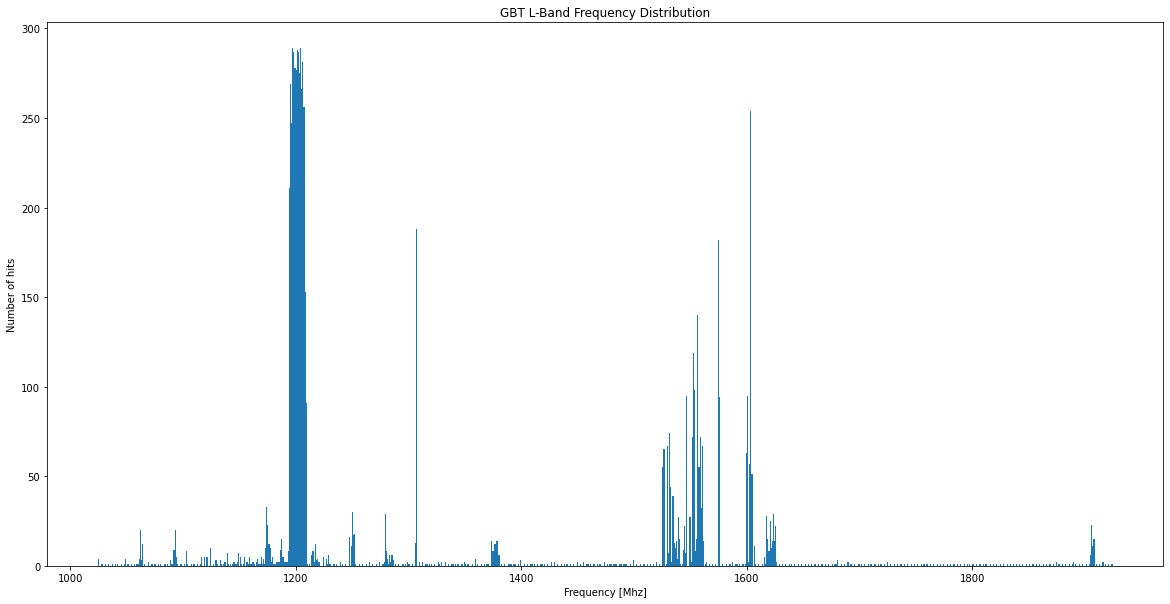

In [4]:
l_band_dat = "LSCX_dats/full_lband/spliced_blc0001020304050607_guppi_58873_11347_TIC159510109_0050.gpuspec.0000.dat"
hist, bin_edges = calculate_hist(l_band_dat)

plt.figure(figsize=(20, 10))
plt.bar(bin_edges[:-1], hist, width=.99)
plt.xlabel("Frequency [Mhz]")
plt.ylabel("Number of hits")
plt.title("GBT L-Band Frequency Distribution")
#plt.savefig("Spectral_Occupancy_original_dat.png")
#plt.xlim(1710, 1750)
plt.show()

When we detect a signal that may be of interest, it is useful to know how much signal in that frequency range is from human sources, because this can give us a measure on the likelihood that the signal originated from somewhere other than Earth. By looking at a large number of samples, we can find which frequency bins are more or less likely to detect some level of signal in any given run. The presence of a signal at a given frequency across many samples tells us that it is a relatively constant source of radio signal, which indicates that it is likely a human caused signal.

In [5]:
def calculate_proportion(file_list, bin_width=1, GBT_L=False, GBT_S=False):
    """Takes in a list of .dat files and makes a true/false table of hits in a frequency bin"""
    edges = []
    histograms = []
    min_freq = 0
    max_freq = 1e9
    
    #calculate histogram for the .dat file and check the boundaries on the data
    for file in file_list:
        hist, bin_edges = calculate_hist(file, bin_width)
        if min(bin_edges) > min_freq:
            min_freq = min(bin_edges)
        if max(bin_edges) < max_freq:
            max_freq = max(bin_edges)
        edges.append(bin_edges)
        histograms.append(hist)
    
    #make sure all lists are within the boundaries
    for i in range(len(edges)):
        within_boundaries = np.where( (edges[i] >= min_freq) & (edges[i] <= max_freq) ) #get the boundaries of the tightest frequency range
        edges[i] = edges[i][within_boundaries] # take only the entries within that range
        freq_boundaries = within_boundaries[0][:-1] # since the bins list has one more entry than frequencies, I will drop the last entry. the hit count will correspond with the frequency at the start of its bin
        histograms[i] = histograms[i][freq_boundaries] # take only the entries within that range
        
    #create the dataframe and add the frequency bins to column 0
    df = pd.DataFrame()
    df.insert(0, "freq", edges[0][:-1])
    
    #check if there is a hit in the frequency bin and insert value to dataframe
    for i in range(len(histograms)):
        colname = "file"+str(i)
        found_hit = histograms[i] > 0
        df.insert(len(df.columns), colname, found_hit.astype(int))
    
    #exclude entries in the GBT data due to the notch filter exclusion
    bin_edges = np.linspace(min_freq, max_freq, int((max_freq-min_freq)/bin_width), endpoint=True)
    if GBT_L:
        df = df[(df["freq"] < 1200) | (df["freq"] > 1341)]
        first_edge = np.arange(min_freq, 1200, bin_width)
        second_edge= np.arange(1341, max_freq, bin_width) #may or may not need max_freq+1
        bin_edges = np.append(first_edge, second_edge)
    
    if GBT_S:
        df = df[(df["freq"] < 2300) | (df["freq"] > 2360)]
        first_edge = np.arange(min_freq, 2300, bin_width)
        second_edge= np.arange(2360, max_freq, bin_width) #may or may not need max_freq+1
        bin_edges = np.append(first_edge, second_edge)

     
    # sum up the number of entries that have a hit and divide by the number of .dat files
    data_labels = df.columns[2:]
    total = df["file0"]
    for label in data_labels:
        total = total + df[label]
    
    return bin_edges, total/len(file_list) 

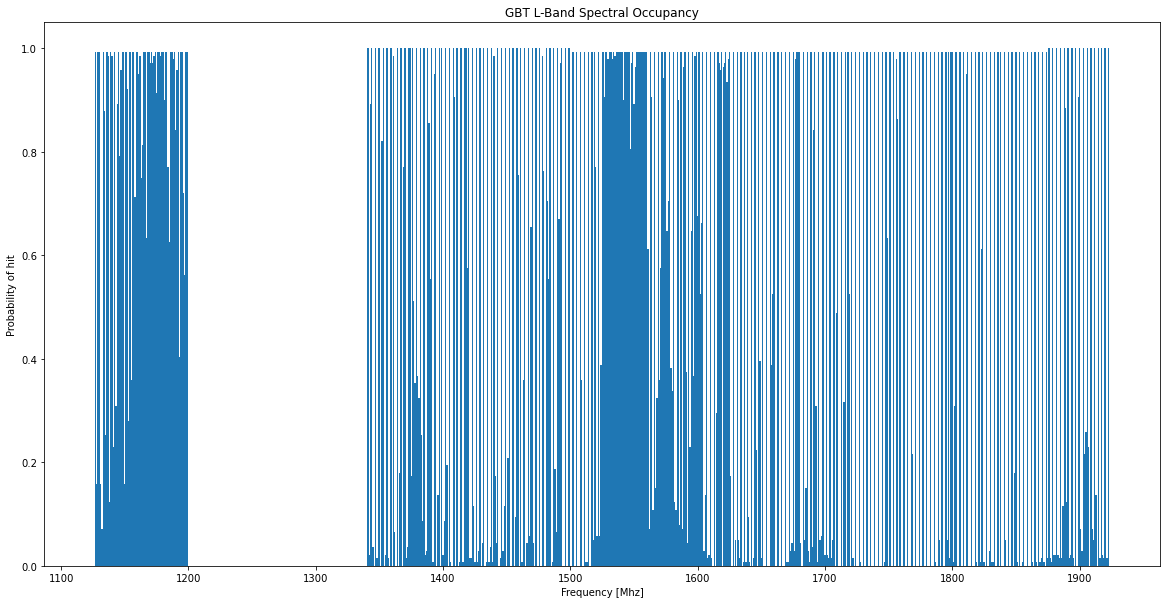

In [6]:
full_lband = glob.glob("full_lband/*0.dat")
bin_edges, prob_hist = calculate_proportion(full_lband, GBT_L=True)

plt.figure(figsize=(20, 10))
plt.bar(bin_edges[:-1], prob_hist, width=.99)
plt.xlabel("Frequency [Mhz]")
plt.ylabel("Probability of hit")
plt.title("GBT L-Band Spectral Occupancy")
plt.show()

In the above spectral occupancy histogram, the gap from 1200-1341 MHz is due to the notch filter on the Green Bank Telescope. There are also near 100% hit rates every 3MHz, which is attributed to a spike in the DC bin at the center of each course channel [Lebofsky et al 2019](https://arxiv.org/pdf/1906.07391.pdf). Since this is a result of the instrumentation, and is not an actual radio signal, they need to be removed to give us a more meaningful spectral occupancy. To do this, I modified code written by Karen Perez, so that it could be used for any of the GBT bands (L, S, C, X) to remove the DC spikes. After removing the DC spikes, we get a cleaner spectral occupancy:

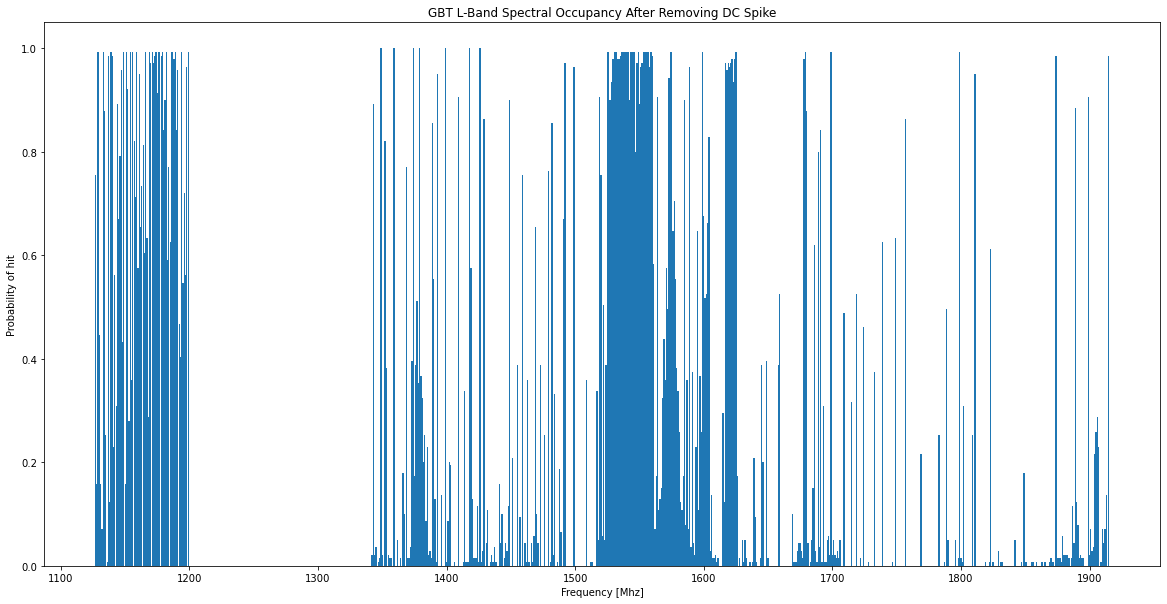

In [7]:
cleaned_lband = glob.glob("full_lband/no_DC_spike/*datnew.dat")
bin_edges, prob_hist = calculate_proportion(cleaned_lband, GBT_L=True)

plt.figure(figsize=(20, 10))
plt.bar(bin_edges[:-1], prob_hist, width=.99)
plt.xlabel("Frequency [Mhz]")
plt.ylabel("Probability of hit")
plt.title("GBT L-Band Spectral Occupancy After Removing DC Spike")
plt.show()

After removing the DC spikes, we now have the spectral occupancy of the radio frequencies in the L-band. As expected, we can see that the bins where there are known sources of RFI have near 100% hit rates, meaning that every .dat file analyzed detected signals in that range. 

The results of removing the DC spike on the other GBT bands are shown below:

#### X-band

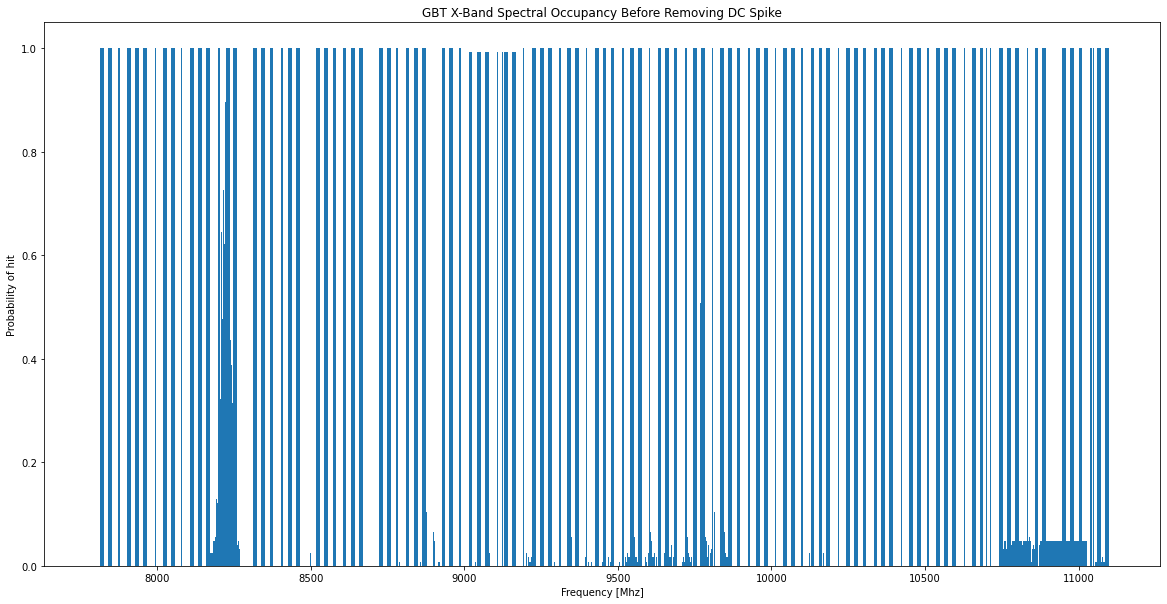

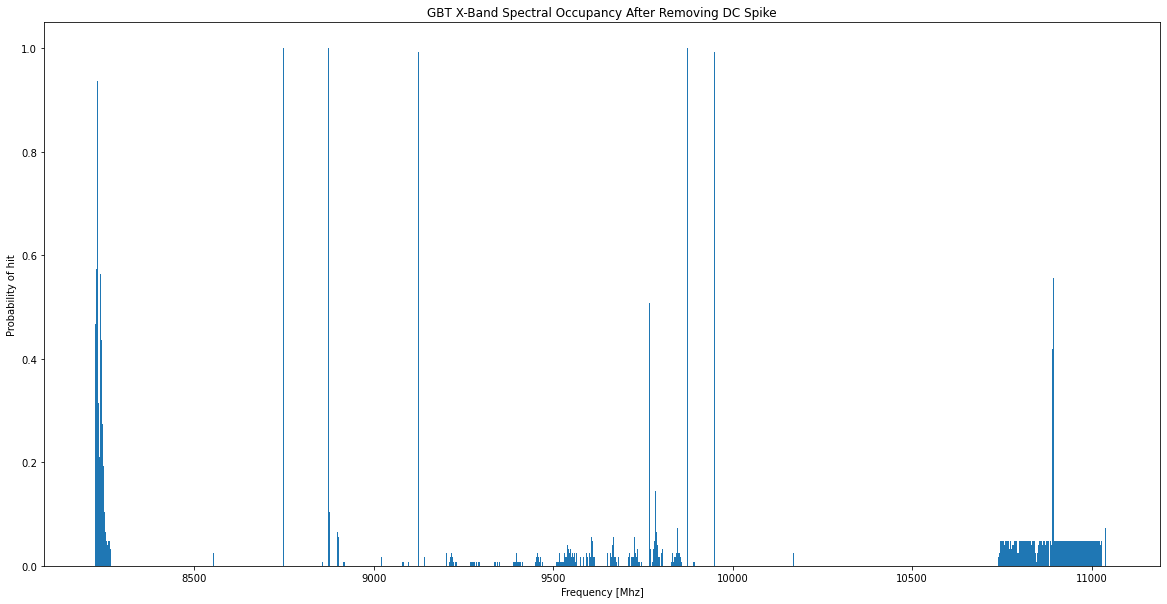

In [8]:
xband = glob.glob("LSCX_dats/full_xband/*0.dat")
bin_edges, prob_hist = calculate_proportion(xband)
plt.figure(figsize=(20, 10))
plt.bar(bin_edges[:-1], prob_hist, width=.99)
plt.xlabel("Frequency [Mhz]")
plt.ylabel("Probability of hit")
plt.title("GBT X-Band Spectral Occupancy Before Removing DC Spike")
plt.show()

cleaned_xband = glob.glob("LSCX_dats/full_xband/no_DC_spike/*datnew.dat")
bin_edges, prob_hist = calculate_proportion(cleaned_xband)
plt.figure(figsize=(20, 10))
plt.bar(bin_edges[:-1], prob_hist, width=.99)
plt.xlabel("Frequency [Mhz]")
plt.ylabel("Probability of hit")
plt.title("GBT X-Band Spectral Occupancy After Removing DC Spike")
plt.show()

#### C-band

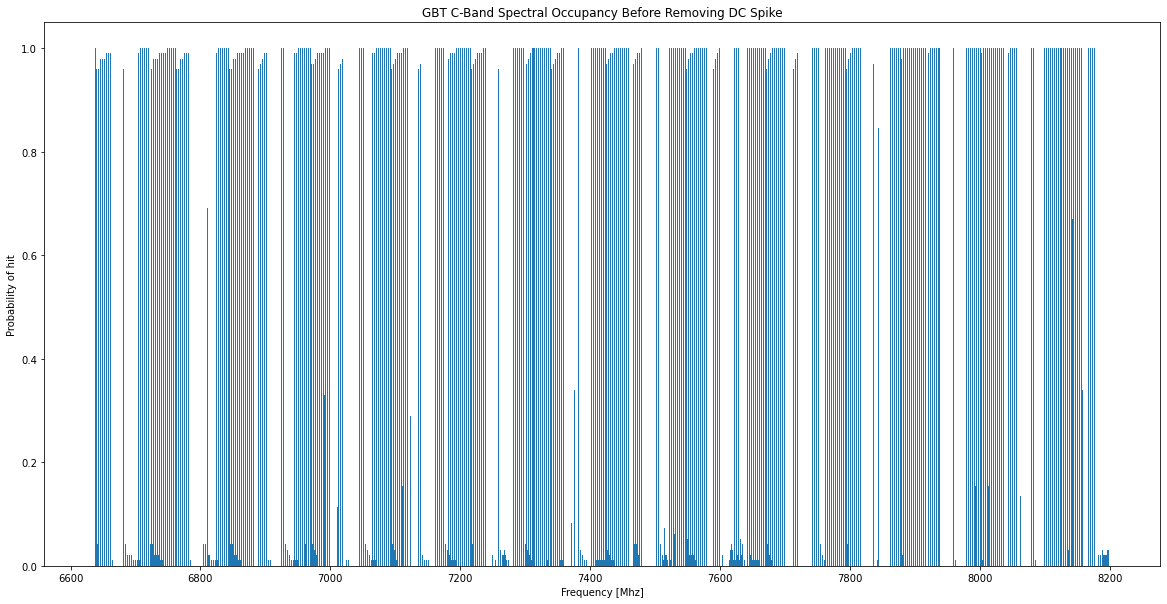

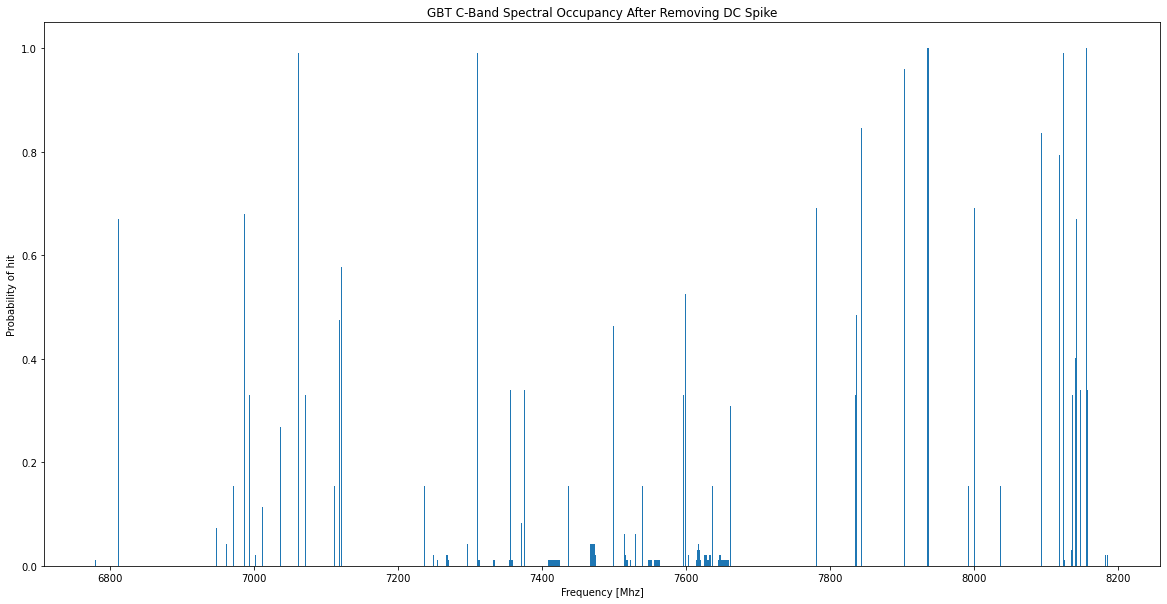

In [9]:
cband = glob.glob("LSCX_dats/full_cband/*0.dat")
bin_edges, prob_hist = calculate_proportion(cband)
plt.figure(figsize=(20, 10))
plt.bar(bin_edges[:-1], prob_hist, width=.99)
plt.xlabel("Frequency [Mhz]")
plt.ylabel("Probability of hit")
plt.title("GBT C-Band Spectral Occupancy Before Removing DC Spike")
plt.show()

cleaned_cband = glob.glob("LSCX_dats/full_cband/no_DC_spike/*datnew.dat")
bin_edges, prob_hist = calculate_proportion(cleaned_cband)
plt.figure(figsize=(20, 10))
plt.bar(bin_edges[:-1], prob_hist, width=.99)
plt.xlabel("Frequency [Mhz]")
plt.ylabel("Probability of hit")
plt.title("GBT C-Band Spectral Occupancy After Removing DC Spike")
plt.show()

#### S-band

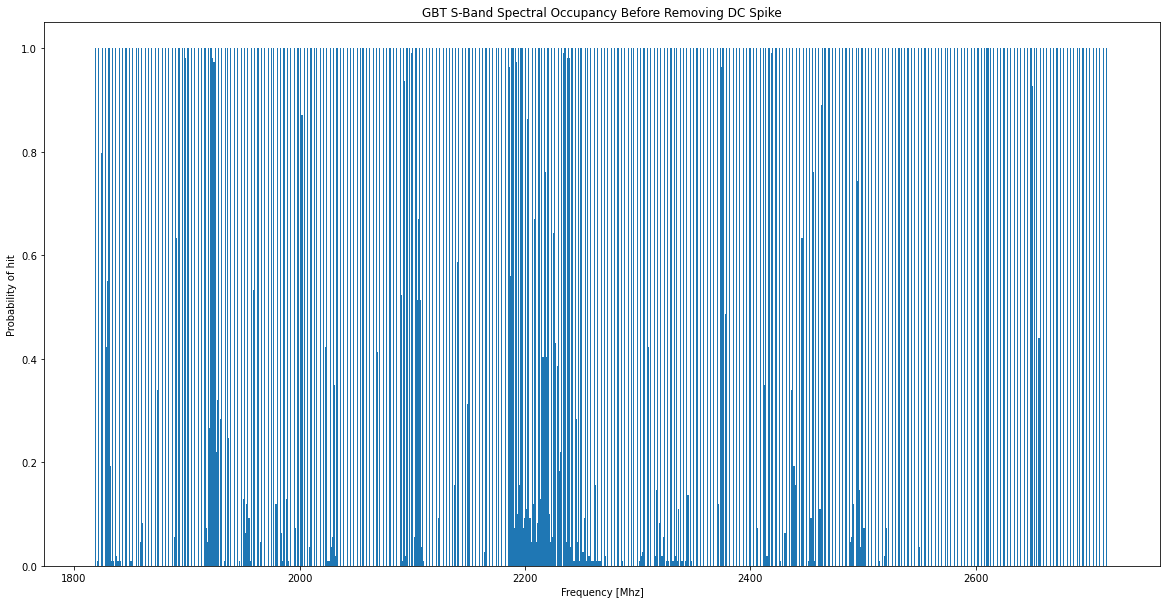

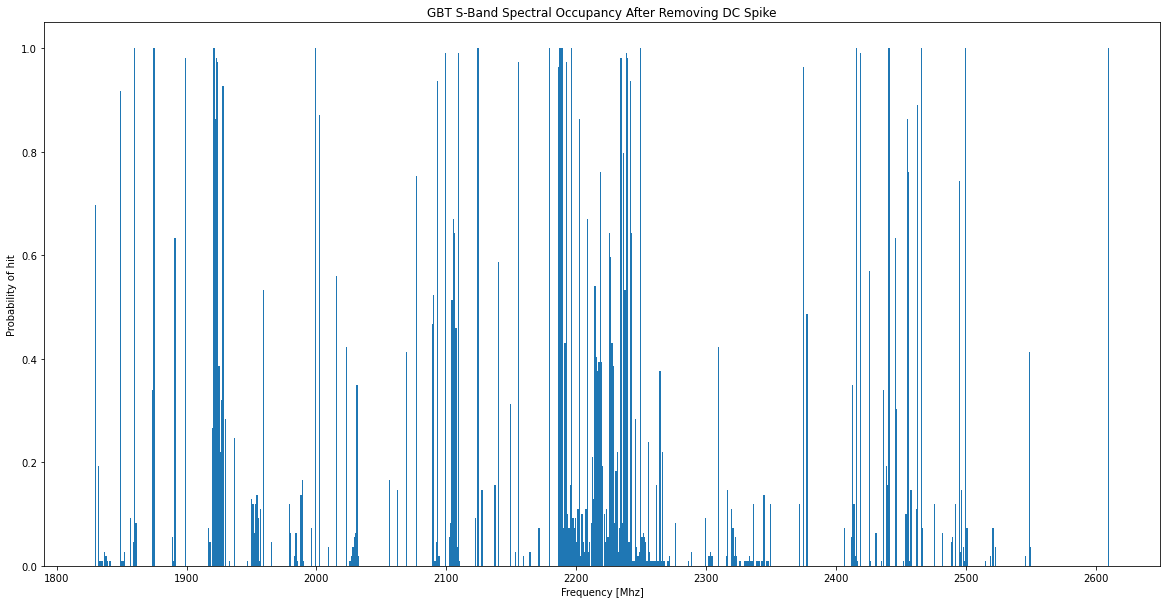

In [10]:
sband = glob.glob("LSCX_dats/full_sband/*0.dat")
bin_edges, prob_hist = calculate_proportion(sband)
plt.figure(figsize=(20, 10))
plt.bar(bin_edges[:-1], prob_hist, width=.99)
plt.xlabel("Frequency [Mhz]")
plt.ylabel("Probability of hit")
plt.title("GBT S-Band Spectral Occupancy Before Removing DC Spike")
plt.show()

cleaned_sband = glob.glob("LSCX_dats/full_sband/no_DC_spike/*datnew.dat")
bin_edges, prob_hist = calculate_proportion(cleaned_sband)
plt.figure(figsize=(20, 10))
plt.bar(bin_edges[:-1], prob_hist, width=.99)
plt.xlabel("Frequency [Mhz]")
plt.ylabel("Probability of hit")
plt.title("GBT S-Band Spectral Occupancy After Removing DC Spike")
plt.show()

Calculating the spectral occupancy of the band allows us to know the likelihood that a signal at a given frequency was caused by human based RFI.  

## Next Steps

Now that the spectral occupancy is working for GBT data, the next thing that could be done is to apply it to data collected from another radio telescope, such as the Murchison Widefield Array (MWA). In order for this to happen, the channel width parameter in the DC spike removal would likley need to by turned into an optional argument so that it can be changed depending on which telescope it is being used to process data for. 

### Acknowledgments

Dr. Steve Croft, for mentorship

Raffy Traas, for providing plenty of GBT .dat files that he processed

Karen Perez, for sharing her DC Spike removal code